In [1]:
# dodajemo sve potrebne importe
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# ucitavanje podataka
train, test = tfds.load( 'emnist/balanced', split=['train', 'test'], shuffle_files=True)
df_train = tfds.as_dataframe( train)
df_test = tfds.as_dataframe( test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteYSC7R8/emnist-train.tfrecord


  0%|          | 0/112800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteYSC7R8/emnist-test.tfrecord


  0%|          | 0/18800 [00:00<?, ? examples/s]

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.


In [3]:
# inicijalno je dataset rotiran za 90 stupnjeva i zrcaljen, mozemo tranirati i na tome, ali mozemo ih i vratiti u originalan oblik
def transform( img):
    img = np.rot90(img, k=-1, axes=(0,1))
    img = np.flip( img, (1))
    return img

In [9]:
# vracanje podataka u originalan oblik
x_train = np.stack( [img for img in df_train['image']])
y_train = df_train['label'].to_numpy()
x_test = np.stack( [img for img in df_test['image']])
y_test = df_test['label'].to_numpy()

In [23]:
y_train = y_train.reshape( (-1, 1))

In [24]:
y_train.shape

(112800, 1)

In [5]:
# funkcija za crtanje
def plot_curve( epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel( 'Epoch')
    plt.ylabel( 'Value')
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot( epochs[1:], x[1:], label=m)
        
    plt.legend()

In [80]:
# definiranje arhitekture modela
def create_model( learning_rate):
    model = tf.keras.models.Sequential()
    
    model.add( tf.keras.layers.Dense( 4, activation='elu'))

    model.add( tf.keras.layers.Conv2D( filters=64, kernel_size=(3,3), activation='elu'))#, input_shape=(28,28,1)))
    model.add( tf.keras.layers.Dropout( rate=0.3))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Conv2D( filters=128, kernel_size=(3,3), activation='elu', padding='same'))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Conv2D( filters=128, kernel_size=(3,3), activation='elu', padding='same'))

    model.add( tf.keras.layers.Flatten())
    model.add( tf.keras.layers.Dense( 64, activation='elu'))
    model.add( tf.keras.layers.Dense( 128, activation='elu'))
    model.add( tf.keras.layers.Dropout( rate=0.3))
    model.add( tf.keras.layers.Dense( 47, activation='softmax'))
    
    model.compile( optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])
    
    return model

# funkcija koja trenira model
def train_model( model, train_features, train_label, epochs,
                    batch_size=None, validation_split=0.1):

    history = model.fit( x=train_features, y=train_label, batch_size=batch_size,
                           epochs=epochs, shuffle=True,
                           validation_split=validation_split)
    
    epochs = history.epoch
    hist = pd.DataFrame( history.history)
    
    return epochs, hist

Epoch 1/113
12/12 [==============================] - 13s 974ms/step - loss: 7.6986 - accuracy: 0.0285 - val_loss: 3.8593 - val_accuracy: 0.0371
Epoch 2/113
12/12 [==============================] - 12s 956ms/step - loss: 3.8262 - accuracy: 0.0505 - val_loss: 3.5760 - val_accuracy: 0.0960
Epoch 3/113
12/12 [==============================] - 12s 958ms/step - loss: 3.4619 - accuracy: 0.1130 - val_loss: 3.1664 - val_accuracy: 0.1947
Epoch 4/113
12/12 [==============================] - 11s 955ms/step - loss: 3.0668 - accuracy: 0.1900 - val_loss: 2.7363 - val_accuracy: 0.2805
Epoch 5/113
12/12 [==============================] - 12s 957ms/step - loss: 2.6520 - accuracy: 0.2776 - val_loss: 2.3507 - val_accuracy: 0.3713
Epoch 6/113
12/12 [==============================] - 12s 956ms/step - loss: 2.2238 - accuracy: 0.3740 - val_loss: 1.8233 - val_accuracy: 0.5094
Epoch 7/113
12/12 [==============================] - 12s 962ms/step - loss: 1.8660 - accuracy: 0.4591 - val_loss: 1.5936 - val_accuracy:

[0.39689379930496216, 0.8715425729751587]

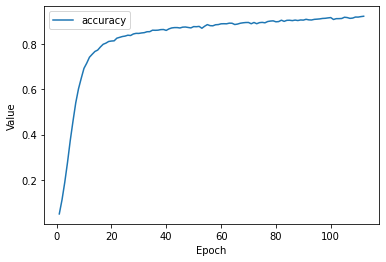

In [84]:

# inicijalizacija nekih hyperparametara
learning_rate = 0.001
epochs = 113
batch_size = 8192
validation_split = 0.2

# stvori model
my_model = create_model( learning_rate)
  
# pokreni treniranje
epochs, hist = train_model( my_model, x_train, y_train,
                                  epochs, batch_size, validation_split)

# nacrtaj graf preciznosti po epohama
list_of_metrics_to_plot = ['accuracy']
plot_curve( epochs, hist, list_of_metrics_to_plot)

# evaluiraj model na test set-u
print("\n Evaluate the new model against the test set:")
my_model.evaluate( x=x_test, y=y_test, batch_size=batch_size)

In [79]:
my_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 28, 28, 4)         8         
                                                                 
 conv2d_95 (Conv2D)          (None, 26, 26, 64)        2368      
                                                                 
 dropout_72 (Dropout)        (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                